In [19]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [20]:
# PREPROCESSING

# loading in the data, then one-hot encoding the target variable (because it's categorical) and scaling the input variables (because they're continuous and on different scales, so we want to normalise them), finally splitting the data into training and testing sets

iris = datasets.load_iris()
X = iris.data
y = iris.target

encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42
)

In [21]:
# FUNCTIONS

# we will need an activation function, I have decided to go with ReLU - the purpose of this function, in simple terms, is to basically round off all negative values to zero and keep the positive values as they are
def relu(x):
    return np.maximum(0, x)

# we will also need a softmax function for the output layer to get the probabilities of each class (3 in this case because of the iris dataset) - we use keepdims=True to keep the dimensions of the output the same as the input so that we can use it in the backpropagation step (which I will define later)
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# now we will define the forward propagation function which will take the input and return the output of the network, you can see that we are using the weights and biases that we initialised earlier and then each step is shown as per the architecture of the network and the defined activation functions for each layer
def forward_propagation(X):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    return A1, A2

# now we will define the loss function, which is the cross-entropy loss function in this case, which is used for classification problems
def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred + 1e-15)) / m
    return loss

# now we will define the backpropagation function which will take the input and the output of the network and return the gradients of the weights and biases
def backward_propagation(X, y_true, A1, A2):
    m = X.shape[0]
    
    dZ2 = A2 - y_true
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * (A1 > 0)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    
    return dW1, db1, dW2, db2

# now we will define the function to update the parameters of the network using the gradients and the learning rate - this works based on the idea of gradient descent, where we update the parameters in the opposite direction of the gradient to minimise the loss function - this is grounded in the idea of calculus, where the gradient of a function at a point gives the direction of the steepest ascent of the function at that point - chain rule is used to calculate the gradients of the weights and biases
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

# now we will define the training function which will take the input, target, number of epochs and learning rate and train the network using the functions we defined earlier - this will simply run the forward and backward propagation functions for the number of epochs specified and print the loss every 100 epochs - at the end of the training, we will have the weights and biases of the network that we can use to make predictions
# Training loop
def train(X_train, y_train, epochs_array, learning_rate_array):
    global W1, b1, W2, b2
    loss_values = {}
    for epochs in epochs_array:
        for learning_rate in learning_rate_array:
            # Reinitialize weights for each combination
            W1 = np.random.randn(input_size, hidden_size)
            b1 = np.zeros((1, hidden_size))
            W2 = np.random.randn(hidden_size, output_size)
            b2 = np.zeros((1, output_size))
            
            losses = []
            for epoch in range(epochs):
                A1, A2 = forward_propagation(X_train)
                loss = compute_loss(y_train, A2)
                dW1, db1, dW2, db2 = backward_propagation(X_train, y_train, A1, A2)
                W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
                
                if epoch % 100 == 0 or epoch == 0 or epoch == epochs - 1:
                    if epoch == 0:
                        print(f"Initial Loss:    {loss:.4f}")
                        continue
                    elif epoch == epochs - 1:
                        print(f"Final Loss:      {loss:.4f}")
                        print()
                        continue
                    print(f"Epoch {epoch}, Loss: {loss:.4f}")
                
                losses.append(loss)
            
            loss_values[(epochs, learning_rate)] = losses
    return loss_values

# now we will define the function to make predictions using the trained network, which will take the input and return the predicted class
def predict(X):
    _, A2 = forward_propagation(X)
    return np.argmax(A2, axis=1)

# now we will define the function to calculate the accuracy of the model, which will take the input and the true target values and return the accuracy of the model
def calculate_accuracy(X, y_true):
    y_pred = predict(X)
    y_true_labels = np.argmax(y_true, axis=1)
    accuracy = np.mean(y_pred == y_true_labels)
    return accuracy

In [22]:
# MLP ARCHITECTURE

# we'll now define the architecture of MLP
input_size = X_train.shape[1]
hidden_size = 10
output_size = y_train.shape[1]

# also initialising weights and biases
# we use np.random.randn() to initialise the weights and np.zeros() to initialise the biases because it's a good practice to initialise the weights randomly and the biases to zero
W1 = np.random.randn(input_size, hidden_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size)
b2 = np.zeros((1, output_size))

In [23]:
# TRAINING

# cut down most of the previous comments - now all we need to do is call the train function with the training data, number of epochs and learning rate - the rest is handled by logic defined earlier
epochs_array = [500, 1000]
learning_rate_array = [0.01, 0.001]
loss_values = train(X_train, y_train, epochs_array, learning_rate_array)

# EVALUATION
train_accuracy = calculate_accuracy(X_train, y_train)
test_accuracy = calculate_accuracy(X_test, y_test)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Print loss values
print("Loss values for each combination of epochs and learning rate:")
for key, value in loss_values.items():
    print(f"Epochs: {key[0]}, Learning Rate: {key[1]}, Losses: {value}")
print()

# Lowest loss value
min_loss = min((min(v), k) for k, v in loss_values.items())
print(f"Lowest loss value: {min_loss[0]:.4f} for {min_loss[1][0]} epochs and learning rate {min_loss[1][1]}")

Initial Loss:    1.9870
Epoch 100, Loss: 0.4016
Epoch 200, Loss: 0.3324
Epoch 300, Loss: 0.2851
Epoch 400, Loss: 0.2486
Final Loss:      0.2180

Initial Loss:    1.9878
Epoch 100, Loss: 1.4639
Epoch 200, Loss: 1.1105
Epoch 300, Loss: 0.8920
Epoch 400, Loss: 0.7537
Final Loss:      0.6636

Initial Loss:    2.8845
Epoch 100, Loss: 0.4806
Epoch 200, Loss: 0.3677
Epoch 300, Loss: 0.3121
Epoch 400, Loss: 0.2757
Epoch 500, Loss: 0.2498
Epoch 600, Loss: 0.2298
Epoch 700, Loss: 0.2137
Epoch 800, Loss: 0.2000
Epoch 900, Loss: 0.1883
Final Loss:      0.1782

Initial Loss:    1.6399
Epoch 100, Loss: 1.3706
Epoch 200, Loss: 1.1569
Epoch 300, Loss: 0.9889
Epoch 400, Loss: 0.8560
Epoch 500, Loss: 0.7496
Epoch 600, Loss: 0.6654
Epoch 700, Loss: 0.5998
Epoch 800, Loss: 0.5492
Epoch 900, Loss: 0.5102
Final Loss:      0.4802

Training Accuracy: 85.83%
Test Accuracy: 90.00%
Loss values for each combination of epochs and learning rate:
Epochs: 500, Learning Rate: 0.01, Losses: [1.802985081534583, 1.630898

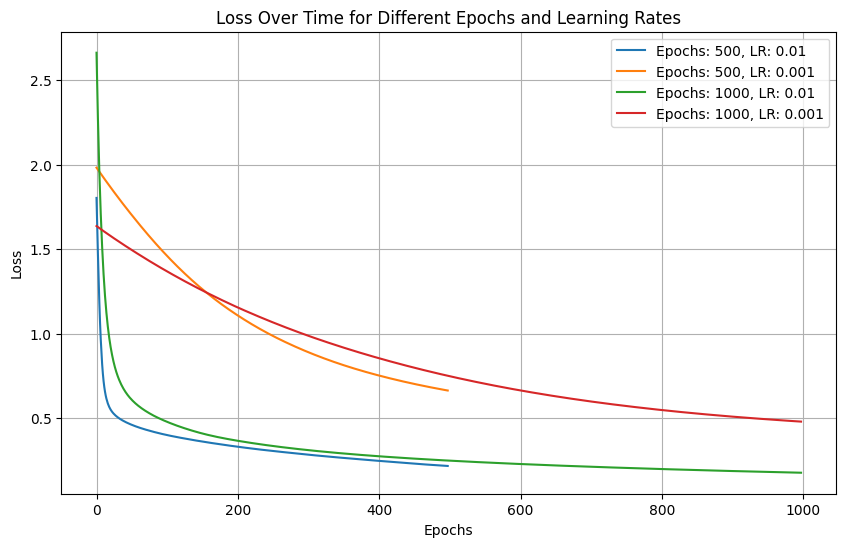

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for (epochs, lr), losses in loss_values.items():
    plt.plot(losses, label=f'Epochs: {epochs}, LR: {lr}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Time for Different Epochs and Learning Rates')
plt.legend()
plt.grid(True)
plt.show()